In [1]:
import torch
import torch.hub
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image
from torchvision import transforms
import cv2
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing
from tqdm import tqdm
import rosbag

import os

from FRM import AutoEncoder, TransformerAutoencoder, legacyAutoEncoder
from feature_dataset import CustomFeatureSensorSceneDataset
from Swin3d import Swin3D_fine_tune, Swin3D

/opt/ros/noetic/lib/python3/dist-packages/rosbag/bag.py:1568: SyntaxWarning: invalid escape sequence '\d'
  matches = re.match("#ROS(.*) V(\d).(\d)", version_line)


In [2]:
model = Swin3D_fine_tune(n_classes=7)

model = torch.load('checkpoints/Swin3d_classifier_all_weights/checkpoint_49.pt',weights_only=False)

model.classifier = nn.Identity()

In [3]:
frm_model = AutoEncoder(input_size=1765,
                        num_encoder_layers=3,
                        num_decoder_layers=2,
                        bottleneck_dim=16,
                        dropout_prob=0.1).cuda()
optimizer = optim.AdamW(frm_model.parameters(), lr= 1e-4, weight_decay=0.1)
criterion = nn.L1Loss()

In [4]:
dataset = CustomFeatureSensorSceneDataset('annotated_toledo_dataset_with_bag.pkl','scene_vectors.pkl')
train_size = int(0.85 * len(dataset))
val_size = int(0.05 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=multiprocessing.cpu_count() // 2,
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=multiprocessing.cpu_count() // 2,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=multiprocessing.cpu_count() // 2,
    pin_memory=True,
    persistent_workers=True
)

In [5]:
num_epochs = 30

train_losses = []
val_losses = []

for epoch in range(num_epochs):

    # -------------- Train --------------------
    frm_model.train()
    train_loss = 0.0
    
    for feature_vector, _, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        
        feature_vector = feature_vector.squeeze(dim=1)

        feature_vector = feature_vector.cuda()
        optimizer.zero_grad()

        output = frm_model(feature_vector)
        loss = criterion(feature_vector,output)

        loss.backward()
        optimizer.step()

        
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # ------------------- Val --------------------------------
    frm_model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for feature_vector, _, _ in val_loader:
            
            feature_vector = feature_vector.squeeze(dim=1)
            feature_vector = feature_vector.cuda()

            output = frm_model(feature_vector)
            loss = criterion(feature_vector, output)

            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

Epoch 1/30: 100%|██████████| 63/63 [00:00<00:00, 173.18it/s]


Epoch 1/30 - Train Loss: 0.6267 - Val Loss: 0.5203


Epoch 2/30: 100%|██████████| 63/63 [00:00<00:00, 695.49it/s]


Epoch 2/30 - Train Loss: 0.5366 - Val Loss: 0.4821


Epoch 3/30: 100%|██████████| 63/63 [00:00<00:00, 718.76it/s]


Epoch 3/30 - Train Loss: 0.5094 - Val Loss: 0.4608


Epoch 4/30: 100%|██████████| 63/63 [00:00<00:00, 666.53it/s]


Epoch 4/30 - Train Loss: 0.4911 - Val Loss: 0.4448


Epoch 5/30: 100%|██████████| 63/63 [00:00<00:00, 692.00it/s]


Epoch 5/30 - Train Loss: 0.4727 - Val Loss: 0.4226


Epoch 6/30: 100%|██████████| 63/63 [00:00<00:00, 725.25it/s]


Epoch 6/30 - Train Loss: 0.4505 - Val Loss: 0.3958


Epoch 7/30: 100%|██████████| 63/63 [00:00<00:00, 734.79it/s]


Epoch 7/30 - Train Loss: 0.4220 - Val Loss: 0.3628


Epoch 8/30: 100%|██████████| 63/63 [00:00<00:00, 700.68it/s]


Epoch 8/30 - Train Loss: 0.3924 - Val Loss: 0.3343


Epoch 9/30: 100%|██████████| 63/63 [00:00<00:00, 705.92it/s]


Epoch 9/30 - Train Loss: 0.3633 - Val Loss: 0.3094


Epoch 10/30: 100%|██████████| 63/63 [00:00<00:00, 719.16it/s]


Epoch 10/30 - Train Loss: 0.3435 - Val Loss: 0.2869


Epoch 11/30: 100%|██████████| 63/63 [00:00<00:00, 719.74it/s]


Epoch 11/30 - Train Loss: 0.3259 - Val Loss: 0.2721


Epoch 12/30: 100%|██████████| 63/63 [00:00<00:00, 739.30it/s]


Epoch 12/30 - Train Loss: 0.3114 - Val Loss: 0.2608


Epoch 13/30: 100%|██████████| 63/63 [00:00<00:00, 719.86it/s]


Epoch 13/30 - Train Loss: 0.3014 - Val Loss: 0.2473


Epoch 14/30: 100%|██████████| 63/63 [00:00<00:00, 734.50it/s]


Epoch 14/30 - Train Loss: 0.2899 - Val Loss: 0.2431


Epoch 15/30: 100%|██████████| 63/63 [00:00<00:00, 681.20it/s]


Epoch 15/30 - Train Loss: 0.2801 - Val Loss: 0.2314


Epoch 16/30: 100%|██████████| 63/63 [00:00<00:00, 724.10it/s]


Epoch 16/30 - Train Loss: 0.2740 - Val Loss: 0.2209


Epoch 17/30: 100%|██████████| 63/63 [00:00<00:00, 769.37it/s]


Epoch 17/30 - Train Loss: 0.2678 - Val Loss: 0.2167


Epoch 18/30: 100%|██████████| 63/63 [00:00<00:00, 747.17it/s]


Epoch 18/30 - Train Loss: 0.2623 - Val Loss: 0.2151


Epoch 19/30: 100%|██████████| 63/63 [00:00<00:00, 702.62it/s]


Epoch 19/30 - Train Loss: 0.2577 - Val Loss: 0.2108


Epoch 20/30: 100%|██████████| 63/63 [00:00<00:00, 714.65it/s]


Epoch 20/30 - Train Loss: 0.2555 - Val Loss: 0.2112


Epoch 21/30: 100%|██████████| 63/63 [00:00<00:00, 685.30it/s]


Epoch 21/30 - Train Loss: 0.2512 - Val Loss: 0.2070


Epoch 22/30: 100%|██████████| 63/63 [00:00<00:00, 682.68it/s]


Epoch 22/30 - Train Loss: 0.2472 - Val Loss: 0.2039


Epoch 23/30: 100%|██████████| 63/63 [00:00<00:00, 730.82it/s]


Epoch 23/30 - Train Loss: 0.2460 - Val Loss: 0.2016


Epoch 24/30: 100%|██████████| 63/63 [00:00<00:00, 725.74it/s]


Epoch 24/30 - Train Loss: 0.2430 - Val Loss: 0.2045


Epoch 25/30: 100%|██████████| 63/63 [00:00<00:00, 774.24it/s]


Epoch 25/30 - Train Loss: 0.2406 - Val Loss: 0.2009


Epoch 26/30: 100%|██████████| 63/63 [00:00<00:00, 704.49it/s]


Epoch 26/30 - Train Loss: 0.2390 - Val Loss: 0.1970


Epoch 27/30: 100%|██████████| 63/63 [00:00<00:00, 702.14it/s]


Epoch 27/30 - Train Loss: 0.2350 - Val Loss: 0.1924


Epoch 28/30: 100%|██████████| 63/63 [00:00<00:00, 753.91it/s]


Epoch 28/30 - Train Loss: 0.2320 - Val Loss: 0.1910


Epoch 29/30: 100%|██████████| 63/63 [00:00<00:00, 742.53it/s]


Epoch 29/30 - Train Loss: 0.2318 - Val Loss: 0.1922


Epoch 30/30: 100%|██████████| 63/63 [00:00<00:00, 723.26it/s]

Epoch 30/30 - Train Loss: 0.2266 - Val Loss: 0.1904


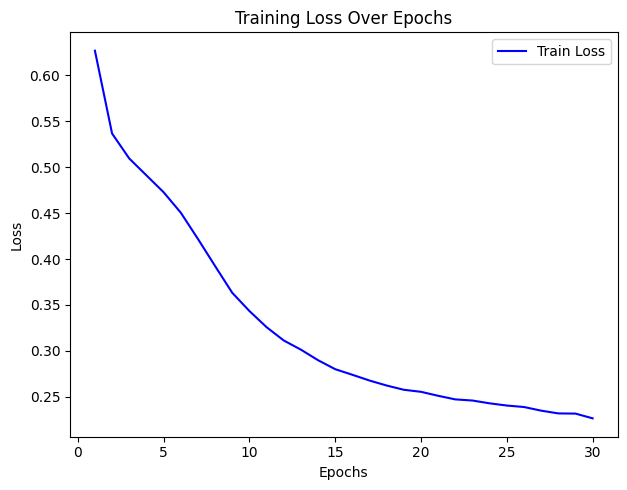

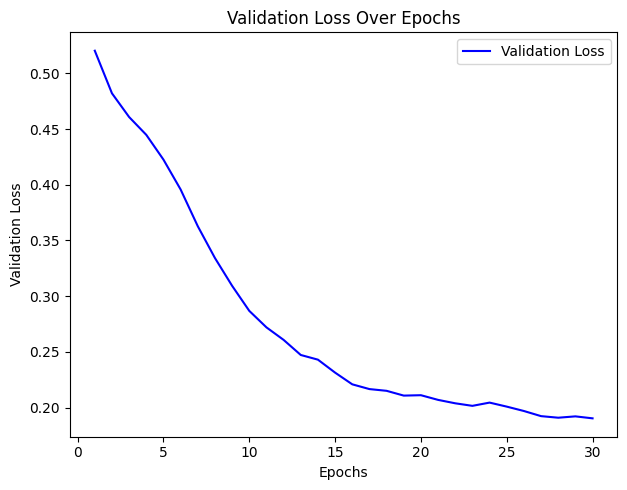

In [6]:
def plot_metrics(train_losses):
    # Convert all elements to CPU floats if they are tensors
    train_losses = [t.cpu().item() if hasattr(t, 'device') else t for t in train_losses]

    epochs = range(1, len(train_losses) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='b')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    plt.tight_layout()
    
    plt.show()
    
    # Plot Val
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, val_losses, label='Validation Loss', color='b')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example call after training
plot_metrics(train_losses)

In [7]:
print(f'Last training loss: {train_losses[-1]}')
print(f'Last validation loss: {val_losses[-1]}')
#print(f'Last lr: {scheduler.get_last_lr()}')

Last training loss: 0.22663088828798325
Last validation loss: 0.19040513038635254


In [8]:
test_epochs = 1
test_losses = []

for epoch in range(test_epochs):
    
    frm_model.eval()  # Set model to evaluation mode
    test_loss = 0.0

    with torch.no_grad():  # No gradient computation
        for feature_vector, _, _ in tqdm(test_loader, desc="Testing"):
            feature_vector = feature_vector.squeeze(dim=1)
            feature_vector = feature_vector.cuda()
            
            output = frm_model(feature_vector)
            loss = criterion(feature_vector, output)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    print(f"Test Loss: {test_loss:.4f}")

Testing: 100%|██████████| 8/8 [00:00<00:00, 64.96it/s]

Test Loss: 0.1924


# Define Threshold:

In [9]:
frm_model.eval()
reconstruction_errors = []

with torch.no_grad():
    for feature_vector, _, _ in tqdm(val_loader, desc="Computing reconstruction errors"):
        
        # Prepare inputs
        feature_vector = feature_vector.squeeze(dim=1).cuda()

        # Forward pass
        output = frm_model(feature_vector)
        
        # Compute L1 reconstruction error per sample using your existing criterion
        # criterion gives a scalar loss if inputs are batched — so compute per sample manually
        errors = torch.mean(torch.abs(feature_vector - output), dim=1)  # L1 per sample

        reconstruction_errors.extend(errors.cpu().numpy())

# Convert to numpy
reconstruction_errors = np.array(reconstruction_errors)

Computing reconstruction errors: 100%|██████████| 4/4 [00:00<00:00, 653.55it/s]


✅ 95th percentile threshold: 0.237570


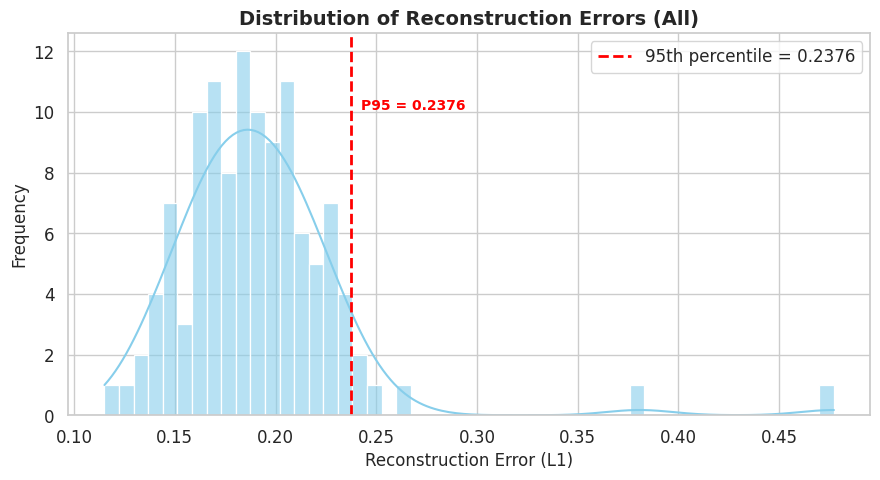

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

threshold_95 = np.percentile(reconstruction_errors, 95)

print(f"✅ 95th percentile threshold: {threshold_95:.6f}")

# --- Plot ---
sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(9, 5))

sns.histplot(reconstruction_errors, bins=50, kde=True, color='skyblue', alpha=0.6)

# Draw line for the 95th percentile
plt.axvline(threshold_95, color='red', linestyle='--', linewidth=2, label=f'95th percentile = {threshold_95:.4f}')

# Annotate
plt.text(threshold_95 * 1.02, plt.ylim()[1] * 0.8,
         f"P95 = {threshold_95:.4f}",
         color='red', fontsize=10, fontweight='bold')

# Labels and title
plt.xlabel("Reconstruction Error (L1)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Reconstruction Errors (All)", fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()
